In [1]:
import pandas as pd
import os
import cv2

group_path = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
group_df = pd.read_excel(group_path)
pred_path = '/data/ceiling/workspace/DLBLC/results/Beijing_all/s_0_checkpoint.csv'
pred_df = pd.read_csv(pred_path)

In [2]:
group_df

,case_id,slide_id,BCL2,MYC,BCL6,mutation,病理号,性别,年龄,"Bcl-2(0-negative,1-positive≥50%）",...,OS(m),BCL2-FISH重排,MYC-FISH重排,BCL6-FISH重排,NGS测序（0无，1有）,测序结果(突变基因；0未显示突变),其他肿瘤史,部位,起源,P53（1野生2突变）
0,L2020-572,L2020-572,1,1,0,1,L2020-572,女,59,1.0,...,NaN,+,+,-,NaN,NaN,NaN,左胸前壁,GC,2
1,L2018-1286,L2018-1286,0,0,1,1,L2018-1286,男,62,1.0,...,NaN,-,-,+,NaN,NaN,NaN,胸5肿瘤,NON-GC,N
2,L2017-2701,L2017-2701,0,0,0,0,L2017-2701,女,63,1.0,...,NaN,-,-,-,NaN,NaN,NaN,胃镜活检,NON-GC,N
3,L2018-0717,L2018-0717,0,0,0,0,L2018-0717,女,42,0.0,...,NaN,-,-,-,NaN,NaN,NaN,卵巢,GC,1
4,20240980,20240980-2,0,0,0,0,会20240980,女,75,NaN,...,NaN,-,-,-,NaN,NaN,NaN,左腋窝淋巴结,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,763650,763650-1,0,0,0,0,763650,女,51,1.0,...,85.433333,-,-,-,0.0,NaN,NaN,NaN,NaN,NaN
1044,22-09755,22-09755,0,0,1,1,22-09755,男,64,1.0,...,18.733333,-,-,+,0.0,NaN,NaN,NaN,NaN,NaN
1045,1113056,1113056-2,0,1,0,1,1113056,女,87,0.0,...,24.400000,-,+,-,1.0,MYC,NaN,NaN,NaN,NaN
1046,24-01818,24-01818,0,0,1,1,24-01818,男,52,NaN,...,10.900000,-,-,+,0.0,NaN,NaN,NaN,NaN,NaN


In [3]:
pred_df

,slide_id,prob_BCL2,prob_MYC,prob_BCL6,label_BCL2,label_MYC,label_BCL6
0,L2020-572,1.000000,0.148888,0.999815,1.0,1.0,0.0
1,L2018-1286,0.013311,0.227130,0.996527,0.0,0.0,1.0
2,L2017-2701,0.000538,0.506340,0.061820,0.0,0.0,0.0
3,L2018-0717,0.001271,0.123438,0.112750,0.0,0.0,0.0
4,20240980-2,0.711437,0.033250,0.313398,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1043,763650-1,0.000037,0.009926,0.109314,0.0,0.0,0.0
1044,22-09755,0.033599,0.000111,1.000000,0.0,0.0,1.0
1045,1113056-2,0.000258,0.686419,0.405102,0.0,1.0,0.0
1046,24-01818,0.029604,0.080994,1.000000,0.0,0.0,1.0


In [22]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Survival analysis of BH-TCH cohort
stratified by model-predicted risk (BCL2 / MYC / BCL6).

生成：
    Kaplan-Meier 曲线  png
    Log-rank p 值、HR  csv
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 0. 路径
# --------------------------------------------------
fold        = 3
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival')
out_dir.mkdir(parents=True, exist_ok=True)

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', 'OS Status', 'OS(m)']],
        on='slide_id', how='left'
     )

TIME_COL   = 'OS(m)'
EVENT_COL  = 'OS Status'
targets    = ['BCL2', 'MYC', 'BCL6']
THR        = 0.5            # 风险阈值（prob ≥ THR 归为 High-risk）

# 丢弃无生存信息的样本
df = df.dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 定义分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    """prob >= thr → 'High', else 'Low'"""
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# --------------------------------------------------
# 3. Kaplan-Meier & log-rank
# --------------------------------------------------
records = []
for tgt in targets:
    prob_col = f'prob_{tgt}'

    df[f'{tgt}_risk'] = df[prob_col].apply(risk_group)

    # 过滤掉分组未知的
    sub = df.dropna(subset=[f'{tgt}_risk'])

    kmf = KaplanMeierFitter()

    plt.figure(figsize=(6, 5))
    for grp, g in sub.groupby(f'{tgt}_risk'):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ci_show=False)

    plt.title(f'{tgt} — Predicted risk groups')
    plt.xlabel('Months')
    plt.ylabel('Overall Survival probability')
    plt.tight_layout()
    plt.savefig(out_dir / f'KM_{tgt}.pdf', dpi=300)
    plt.close()

    # log-rank 检验
    g_high = sub.query(f'{tgt}_risk == "High"')
    g_low  = sub.query(f'{tgt}_risk == "Low"')
    lr_res = statistics.logrank_test(
        g_high[TIME_COL], g_low[TIME_COL],
        g_high[EVENT_COL], g_low[EVENT_COL]
    )

    # Cox 回归（prob 连续变量）
    cph_df = sub[[TIME_COL, EVENT_COL, prob_col]].copy()
    cph_df.rename(columns={prob_col: 'prob'}, inplace=True)
    cph = CoxPHFitter()
    try:
        cph.fit(cph_df, duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['prob'])
        hr_ci = cph.confidence_intervals_.loc['prob'].values
        cox_p = cph.summary.loc['prob', 'p']
    except Exception:
        hr = hr_ci = cox_p = np.nan

    records.append({
        'Target'      : tgt,
        'High_N'      : len(g_high),
        'Low_N'       : len(g_low),
        'Logrank_p'   : lr_res.p_value,
        'HR(prob)'    : hr,
        'HR 95% CI L' : hr_ci[0] if isinstance(hr_ci, (list, np.ndarray)) else np.nan,
        'HR 95% CI U' : hr_ci[1] if isinstance(hr_ci, (list, np.ndarray)) else np.nan,
        'Cox_p'       : cox_p,
    })

# --------------------------------------------------
# 4. 保存统计结果
# --------------------------------------------------
stats_df = pd.DataFrame(records)
stats_df.to_csv(out_dir / f'survival_stats_fold{fold}.csv', index=False)

print(f'分析完成。结果文件和 KM 图已保存到：{out_dir}')
print(stats_df)

分析完成。结果文件和 KM 图已保存到：/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival
  Target  High_N  Low_N  Logrank_p  HR(prob)  HR 95% CI L  HR 95% CI U  \
0   BCL2     115    471   0.009231  1.755277     0.123733     1.001521   
1    MYC      91    495   0.000003  2.932864     0.656588     1.495371   
2   BCL6     292    294   0.096478  0.643922    -0.875983    -0.004373   

          Cox_p  
0  1.198737e-02  
1  4.945078e-07  
2  4.774518e-02  


# prob 单marker的 OS 预测

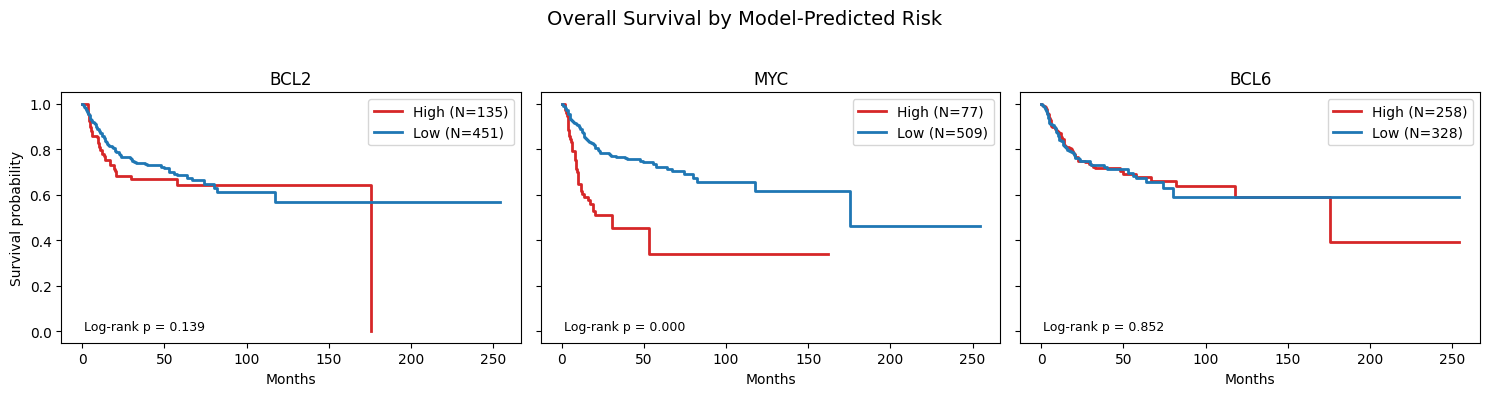

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_singe_prob_OS/KM_3targets_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_singe_prob_OS/survival_stats_fold4.csv
  Target  High_N  Low_N     Logrank_p  HR(prob)  HR 95% CI L  HR 95% CI U  \
0   BCL2     135    451  1.391273e-01  1.206964    -0.267889     0.644106   
1    MYC      77    509  1.151446e-09  3.516311     0.825978     1.688847   
2   BCL6     258    328  8.517488e-01  1.080362    -0.343349     0.497941   

          Cox_p  
0  4.187880e-01  
1  1.114578e-08  
2  7.187313e-01  


In [27]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_singe_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'       # 生存时间（月）
EVENT_COL  = 'OS Status'   # 1 = 死亡(事件)；0 = 存活/删失
THR        = 0.5           # 概率阈值
targets    = ['BCL2', 'MYC', 'BCL6']

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# --------------------------------------------------
# 3. 画 3 个 KM 图
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle('Overall Survival by Model-Predicted Risk', fontsize=14)

stats_records = []

for ax, tgt in zip(axes, targets):
    prob_col = f'prob_{tgt}'
    df[f'{tgt}_risk'] = df[prob_col].apply(risk_group)
    sub = df.dropna(subset=[f'{tgt}_risk'])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(f'{tgt}_risk'):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp, None), lw=2)

    # log-rank
    hi = sub.query(f'{tgt}_risk=="High"')
    lo = sub.query(f'{tgt}_risk=="Low"')
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(tgt)
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3f}',
            transform=ax.transAxes, fontsize=9)

    # 记录统计量
    stats_records.append({
        'Target' : tgt,
        'High_N' : len(hi),
        'Low_N'  : len(lo),
        'Logrank_p': lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])            # 让标题不被遮挡
plt.savefig(out_dir / f'KM_3targets_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 4. Cox 回归 & 保存统计表
# --------------------------------------------------
for rec, tgt in zip(stats_records, targets):
    prob_col = f'prob_{tgt}'
    sub = df[[TIME_COL, EVENT_COL, prob_col]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={prob_col: 'prob'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['prob'])
        ci_l, ci_u = cph.confidence_intervals_.loc['prob']
        rec.update({'HR(prob)': hr, 'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u, 'Cox_p': cph.summary.loc['prob', 'p']})
    except Exception:
        rec.update({'HR(prob)': np.nan, 'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan, 'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_3targets_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_stats_fold{fold}.csv')
print(stats_df)

# label做OS预测

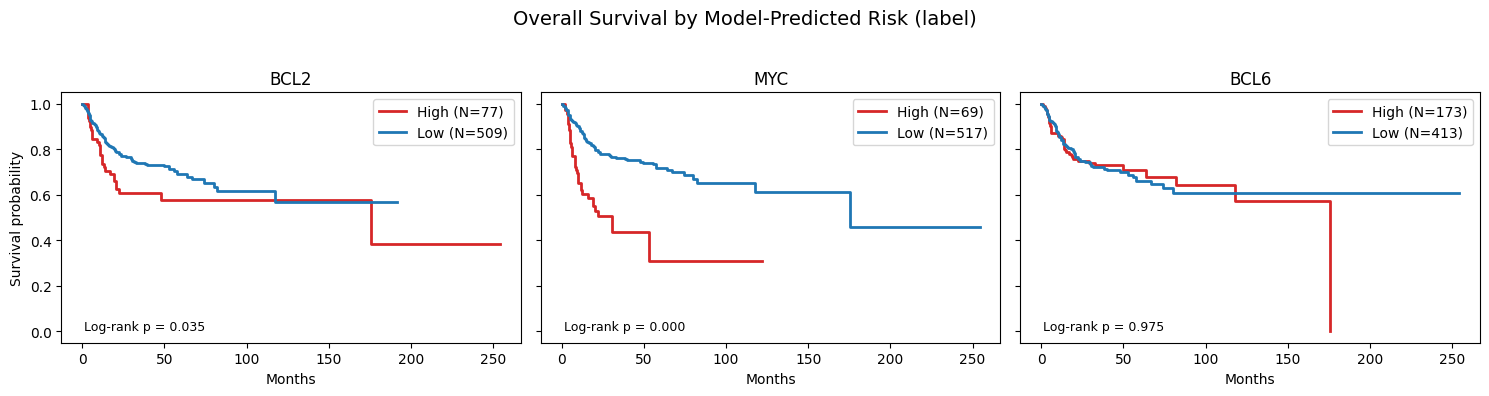

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_OS/KM_3targets_label_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_OS/survival_stats_label_fold4.csv
  Target  High_N  Low_N     Logrank_p  HR(label=1 vs 0)  HR 95% CI L  \
0   BCL2      77    509  3.463974e-02          1.538455     0.028333   
1    MYC      69    517  5.549294e-09          2.902132     0.690569   
2   BCL6     173    413  9.747173e-01          1.005351    -0.339757   

   HR 95% CI U         Cox_p  
0     0.833224  3.590942e-02  
1     1.440322  2.540637e-08  
2     0.350431  9.758199e-01  


In [32]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Overall Survival）
按模型输出的 label_{gene} (0=Low, 1=High) 分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'       # 生存时间（月）
EVENT_COL  = 'OS Status'   # 1 = 死亡(事件)；0 = 存活/删失
targets    = ['BCL2', 'MYC', 'BCL6']      # 需要存在 label_{gene} 列

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 画 3 个 KM 图
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle('Overall Survival by Model-Predicted Risk (label)', fontsize=14)

stats_records = []

for ax, tgt in zip(axes, targets):
    lbl_col = f'label_{tgt}'
    if lbl_col not in df.columns:
        raise ValueError(f'找不到列 {lbl_col}，请确认预测文件包含该列')

    # 映射成 High / Low
    df[f'{tgt}_risk'] = df[lbl_col].map({1: 'High', 0: 'Low'})
    sub = df.dropna(subset=[f'{tgt}_risk'])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    # 逐组画曲线
    for grp, g in sub.groupby(f'{tgt}_risk'):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp, None), lw=2)

    # log-rank 检验
    hi = sub.query(f'{tgt}_risk=="High"')
    lo = sub.query(f'{tgt}_risk=="Low"')
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(tgt)
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3f}',
            transform=ax.transAxes, fontsize=9)

    # 记录统计量
    stats_records.append({
        'Target' : tgt,
        'High_N' : len(hi),
        'Low_N'  : len(lo),
        'Logrank_p': lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_3targets_label_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 4. Cox 回归 & 保存统计表
#    这里把 label (0/1) 当作一个二分类自变量。
# --------------------------------------------------
for rec, tgt in zip(stats_records, targets):
    lbl_col = f'label_{tgt}'
    sub = df[[TIME_COL, EVENT_COL, lbl_col]].dropna()
    cph = CoxPHFitter()

    try:
        # 将列统一命名为 'label' 方便拟合
        cph.fit(sub.rename(columns={lbl_col: 'label'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['label'])
        ci_l, ci_u = cph.confidence_intervals_.loc['label']
        rec.update({'HR(label=1 vs 0)': hr,
                    'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u,
                    'Cox_p': cph.summary.loc['label', 'p']})
    except Exception:
        rec.update({'HR(label=1 vs 0)': np.nan,
                    'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan,
                    'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_stats_label_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_3targets_label_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_stats_label_fold{fold}.csv')
print(stats_df)

# prob DFS

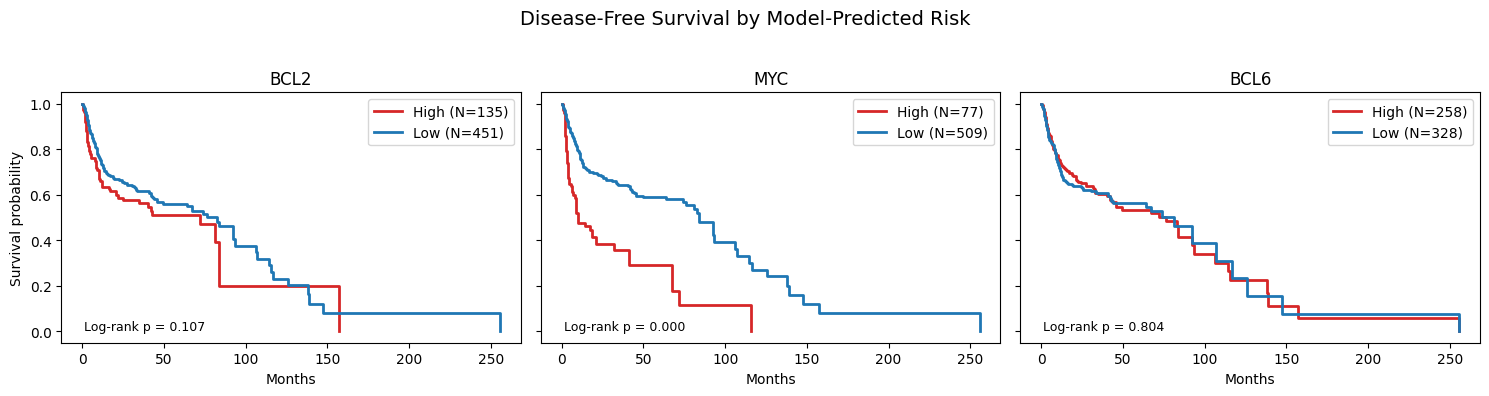

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_prob_DFS/KM_DFS_3targets_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_prob_DFS/survival_DFS_stats_fold4.csv
  Target  High_N  Low_N     Logrank_p  HR(prob)  HR 95% CI L  HR 95% CI U  \
0   BCL2     135    451  1.066413e-01  1.244453    -0.148479     0.585871   
1    MYC      77    509  1.011264e-10  3.103678     0.762720     1.502456   
2   BCL6     258    328  8.041453e-01  1.031384    -0.300941     0.362743   

          Cox_p  
0  2.430527e-01  
1  1.952857e-09  
2  8.551805e-01  


In [37]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Disease-Free Survival）
按模型预测风险（prob ≥ THR → High）分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_prob_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'       # 生存时间（月）---------★ 改这里
EVENT_COL  = 'DFS Status'   # 1 = 复发/死亡；0 = 随访/删失 ---★ 改这里
THR        = 0.5            # 概率阈值
targets    = ['BCL2', 'MYC', 'BCL6']

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 分组函数
# --------------------------------------------------
def risk_group(prob, thr=THR):
    try:
        return 'High' if float(prob) >= thr else 'Low'
    except (ValueError, TypeError):
        return np.nan

# --------------------------------------------------
# 3. 画 3 个 KM 图
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle('Disease-Free Survival by Model-Predicted Risk', fontsize=14)

stats_records = []

for ax, tgt in zip(axes, targets):
    prob_col = f'prob_{tgt}'
    df[f'{tgt}_risk'] = df[prob_col].apply(risk_group)
    sub = df.dropna(subset=[f'{tgt}_risk'])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(f'{tgt}_risk'):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp, None), lw=2)

    # log-rank
    hi = sub.query(f'{tgt}_risk=="High"')
    lo = sub.query(f'{tgt}_risk=="Low"')
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(tgt)
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3f}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Target'   : tgt,
        'High_N'   : len(hi),
        'Low_N'    : len(lo),
        'Logrank_p': lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_DFS_3targets_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 4. Cox 回归 & 保存统计表
# --------------------------------------------------
for rec, tgt in zip(stats_records, targets):
    prob_col = f'prob_{tgt}'
    sub = df[[TIME_COL, EVENT_COL, prob_col]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={prob_col: 'prob'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['prob'])
        ci_l, ci_u = cph.confidence_intervals_.loc['prob']
        rec.update({'HR(prob)': hr, 'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u, 'Cox_p': cph.summary.loc['prob', 'p']})
    except Exception:
        rec.update({'HR(prob)': np.nan, 'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan, 'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_DFS_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_DFS_3targets_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_DFS_stats_fold{fold}.csv')
print(stats_df)

# label DFS

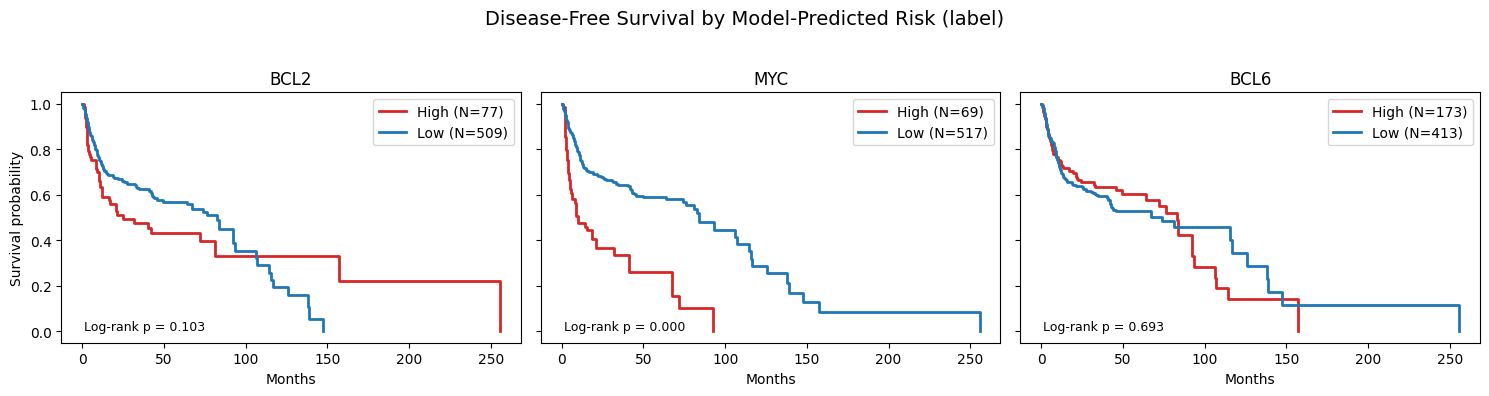

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_DFS/KM_DFS_3targets_label_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_DFS/survival_DFS_stats_label_fold4.csv
  Target  High_N  Low_N     Logrank_p  HR(label=1 vs 0)  HR 95% CI L  \
0   BCL2      77    509  1.028929e-01          1.322707    -0.057989   
1    MYC      69    517  8.575248e-12          2.860372     0.736677   
2   BCL6     173    413  6.928132e-01          0.946389    -0.331390   

   HR 95% CI U         Cox_p  
0     0.617350  1.045099e-01  
1     1.365227  5.593380e-11  
2     0.221187  6.958819e-01  


In [42]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 生存分析（Disease-Free Survival, DFS）
按模型输出的 label_{gene} (0=Low, 1=High) 分组，
一次性绘制 BCL2 / MYC / BCL6 共 3 张 KM 曲线，并做单变量 Cox 回归。

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_single_label_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'       # 随访时间（月）
EVENT_COL  = 'DFS Status'   # 1 = 复发/死亡(事件)；0 = 随访/删失
targets    = ['BCL2', 'MYC', 'BCL6']  # 需有 label_{gene} 列

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 绘制 3 张 KM 图
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle('Disease-Free Survival by Model-Predicted Risk (label)', fontsize=14)

stats_records = []

for ax, tgt in zip(axes, targets):
    lbl_col = f'label_{tgt}'
    if lbl_col not in df.columns:
        raise ValueError(f'找不到列 {lbl_col}，请检查预测文件')

    # 0/1 → Low/High
    df[f'{tgt}_risk'] = df[lbl_col].map({1: 'High', 0: 'Low'})
    sub = df.dropna(subset=[f'{tgt}_risk'])

    # 绘制 KM
    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(f'{tgt}_risk'):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

    # log-rank 检验
    hi = sub.query(f'{tgt}_risk=="High"')
    lo = sub.query(f'{tgt}_risk=="Low"')
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(tgt)
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3f}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Target'   : tgt,
        'High_N'   : len(hi),
        'Low_N'    : len(lo),
        'Logrank_p': lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_DFS_3targets_label_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 4. Cox 回归 & 保存统计表
# --------------------------------------------------
for rec, tgt in zip(stats_records, targets):
    lbl_col = f'label_{tgt}'
    sub = df[[TIME_COL, EVENT_COL, lbl_col]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={lbl_col: 'label'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['label'])
        ci_l, ci_u = cph.confidence_intervals_.loc['label']
        rec.update({'HR(label=1 vs 0)': hr,
                    'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u,
                    'Cox_p': cph.summary.loc['label', 'p']})
    except Exception:
        rec.update({'HR(label=1 vs 0)': np.nan,
                    'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan,
                    'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_DFS_stats_label_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_DFS_3targets_label_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_DFS_stats_label_fold{fold}.csv')
print(stats_df)

# co-expression label OS

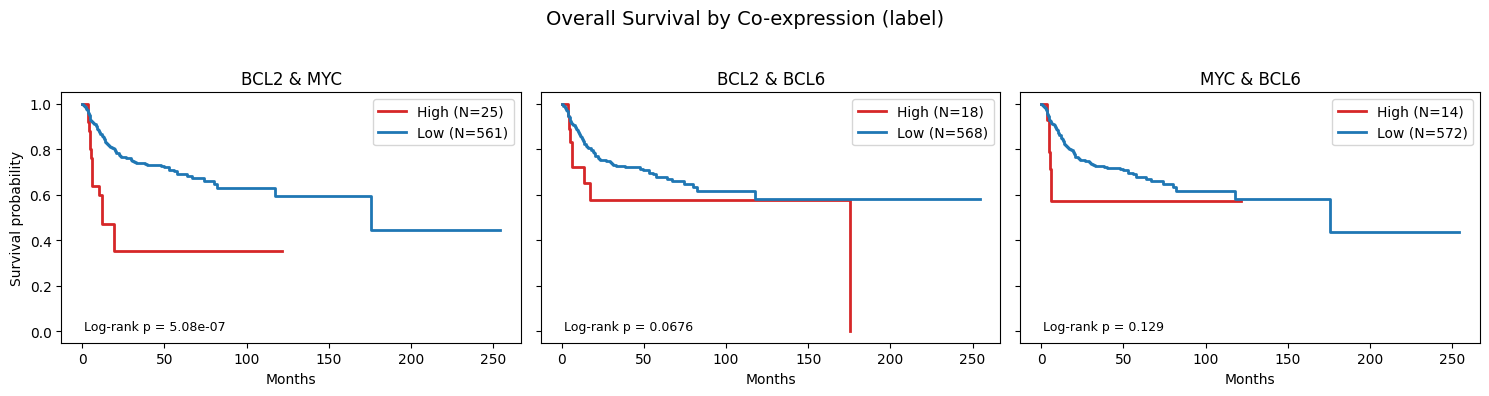

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_OS/KM_pair_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_OS/survival_pair_stats_fold4.csv
        Pair  High_N  Low_N     Logrank_p  HR(pair=1 vs 0)  HR 95% CI L  \
0   BCL2_MYC      25    561  5.082532e-07         3.617299     0.749482   
1  BCL2_BCL6      18    568  6.756900e-02         1.932216    -0.060102   
2   MYC_BCL6      14    572  1.288632e-01         1.865996    -0.194305   

   HR 95% CI U     Cox_p  
0     1.821973  0.000003  
1     1.377438  0.072482  
2     1.441895  0.135056  


In [47]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH co-expression Overall Survival

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'OS Status'    # 或 'DFS Status'

# 要做共表达的基因对（不重复即可）
gene_pairs = [('BCL2', 'MYC'),
              ('BCL2', 'BCL6'),
              ('MYC',  'BCL6')]

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成共表达高危标记
# --------------------------------------------------
for g1, g2 in gene_pairs:
    col1, col2 = f'label_{g1}', f'label_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')
    pair_lbl = f'{g1}_{g2}_pair'          # 0/1 列
    df[pair_lbl] = ((df[col1] == 1) & (df[col2] == 1)).astype(int)
    df[f'{g1}_{g2}_risk'] = df[pair_lbl].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, axes = plt.subplots(1, len(gene_pairs), figsize=(5*len(gene_pairs), 4), sharey=True)
fig.suptitle('Overall Survival by Co-expression (label)', fontsize=14)

stats_records = []

for ax, (g1, g2) in zip(axes, gene_pairs):
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(risk_col):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

    # log-rank
    hi = sub[sub[risk_col] == 'High']
    lo = sub[sub[risk_col] == 'Low']
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(f'{g1} & {g2}')
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Pair'      : f'{g1}_{g2}',
        'High_N'    : len(hi),
        'Low_N'     : len(lo),
        'Logrank_p' : lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_pair_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
for rec, (g1, g2) in zip(stats_records, gene_pairs):
    pair_lbl = f'{g1}_{g2}_pair'   # 0/1
    sub = df[[TIME_COL, EVENT_COL, pair_lbl]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={pair_lbl: 'pair'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['pair'])
        ci_l, ci_u = cph.confidence_intervals_.loc['pair']
        rec.update({'HR(pair=1 vs 0)': hr,
                    'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u,
                    'Cox_p': cph.summary.loc['pair', 'p']})
    except Exception:
        rec.update({'HR(pair=1 vs 0)': np.nan,
                    'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan,
                    'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_pair_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_pair_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_pair_stats_fold{fold}.csv')
print(stats_df)

# 共表达prob OS预测

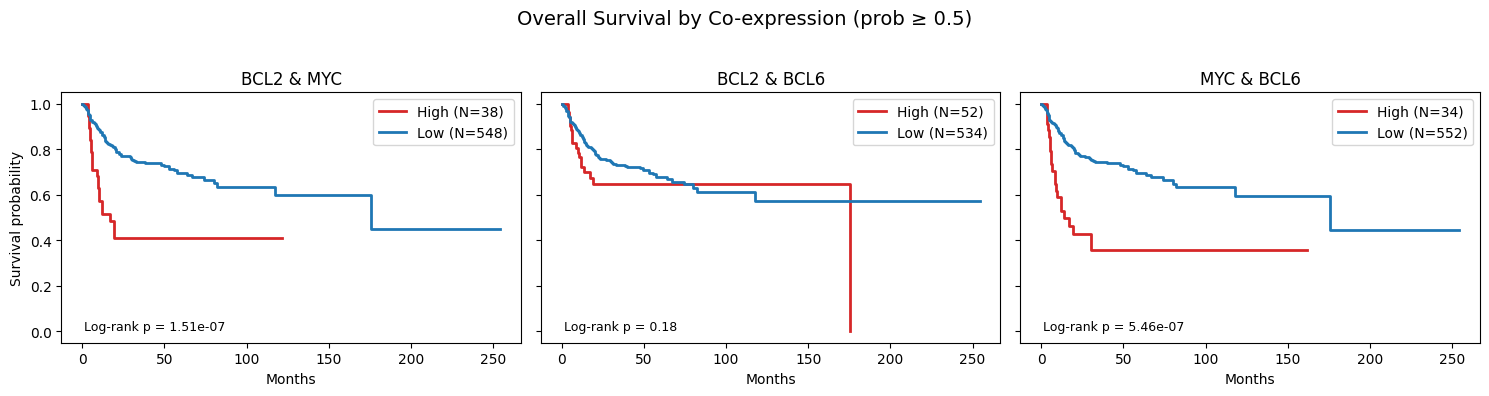

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_OS/KM_pair_prob_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_OS/survival_pair_prob_stats_fold4.csv
        Pair  High_N  Low_N     Logrank_p  HR(pair=1 vs 0)  HR 95% CI L  \
0   BCL2_MYC      38    548  1.509556e-07         3.234603     0.710685   
1  BCL2_BCL6      52    534  1.795755e-01         1.398846    -0.156782   
2   MYC_BCL6      34    552  5.457348e-07         3.137993     0.672113   

   HR 95% CI U         Cox_p  
0     1.637128  6.800101e-07  
1     0.828076  1.815682e-01  
2     1.615053  1.994015e-06  


In [52]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Beijing co-expression（prob，Overall Survival）

High : 同一张片在两个基因上的预测概率都 ≥ THR  
Low  : 其他任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'OS Status'    # 或 'DFS Status'
THR        = 0.5            # 概率阈值

# 要做共表达的基因对（不重复即可）
gene_pairs = [('BCL2', 'MYC'),
              ('BCL2', 'BCL6'),
              ('MYC',  'BCL6')]

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成共表达高危标记
# --------------------------------------------------
for g1, g2 in gene_pairs:
    col1, col2 = f'prob_{g1}', f'prob_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')

    pair_prob_lbl = f'{g1}_{g2}_pair'         # 0/1 列
    df[pair_prob_lbl] = (
        (df[col1] >= THR) & (df[col2] >= THR)
    ).astype(int)

    df[f'{g1}_{g2}_risk'] = df[pair_prob_lbl].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, axes = plt.subplots(
    1, len(gene_pairs), figsize=(5*len(gene_pairs), 4), sharey=True
)
fig.suptitle(
    f'Overall Survival by Co-expression (prob ≥ {THR})', fontsize=14
)

stats_records = []

for ax, (g1, g2) in zip(axes, gene_pairs):
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(risk_col):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

    # log-rank 检验
    hi = sub[sub[risk_col] == 'High']
    lo = sub[sub[risk_col] == 'Low']
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(f'{g1} & {g2}')
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Pair'      : f'{g1}_{g2}',
        'High_N'    : len(hi),
        'Low_N'     : len(lo),
        'Logrank_p' : lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_pair_prob_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
for rec, (g1, g2) in zip(stats_records, gene_pairs):
    pair_lbl = f'{g1}_{g2}_pair'
    sub = df[[TIME_COL, EVENT_COL, pair_lbl]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={pair_lbl: 'pair'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['pair'])
        ci_l, ci_u = cph.confidence_intervals_.loc['pair']
        rec.update({'HR(pair=1 vs 0)': hr,
                    'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u,
                    'Cox_p': cph.summary.loc['pair', 'p']})
    except Exception:
        rec.update({'HR(pair=1 vs 0)': np.nan,
                    'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan,
                    'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_pair_prob_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_pair_prob_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_pair_prob_stats_fold{fold}.csv')
print(stats_df)

# co-expression label DFS

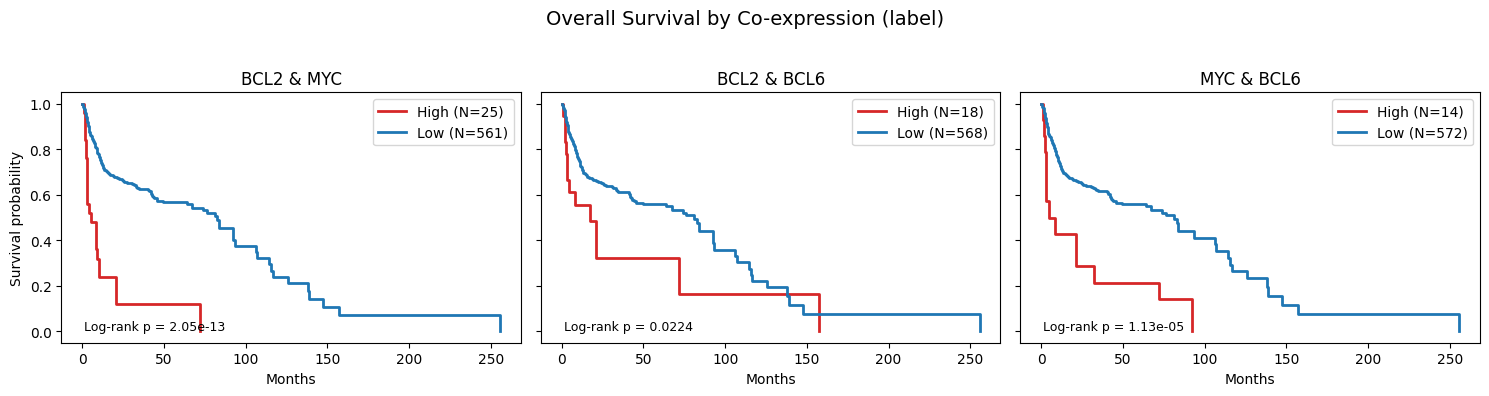

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_DFS/KM_pair_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_DFS/survival_pair_stats_fold4.csv
        Pair  High_N  Low_N     Logrank_p  HR(pair=1 vs 0)  HR 95% CI L  \
0   BCL2_MYC      25    561  2.045029e-13         4.560559     1.073489   
1  BCL2_BCL6      18    568  2.241826e-02         1.923717     0.082832   
2   MYC_BCL6      14    572  1.132657e-05         3.204976     0.620299   

   HR 95% CI U         Cox_p  
0     1.961402  2.096186e-11  
1     1.225686  2.482759e-02  
2     1.709110  2.750949e-05  


In [57]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH co-expression（Overall Survival）

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_label_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'DFS Status'    # 或 'DFS Status'

# 要做共表达的基因对（不重复即可）
gene_pairs = [('BCL2', 'MYC'),
              ('BCL2', 'BCL6'),
              ('MYC',  'BCL6')]

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成共表达高危标记
# --------------------------------------------------
for g1, g2 in gene_pairs:
    col1, col2 = f'label_{g1}', f'label_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')
    pair_lbl = f'{g1}_{g2}_pair'          # 0/1 列
    df[pair_lbl] = ((df[col1] == 1) & (df[col2] == 1)).astype(int)
    df[f'{g1}_{g2}_risk'] = df[pair_lbl].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, axes = plt.subplots(1, len(gene_pairs), figsize=(5*len(gene_pairs), 4), sharey=True)
fig.suptitle('Overall Survival by Co-expression (label)', fontsize=14)

stats_records = []

for ax, (g1, g2) in zip(axes, gene_pairs):
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(risk_col):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

    # log-rank
    hi = sub[sub[risk_col] == 'High']
    lo = sub[sub[risk_col] == 'Low']
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(f'{g1} & {g2}')
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Pair'      : f'{g1}_{g2}',
        'High_N'    : len(hi),
        'Low_N'     : len(lo),
        'Logrank_p' : lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_pair_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
for rec, (g1, g2) in zip(stats_records, gene_pairs):
    pair_lbl = f'{g1}_{g2}_pair'   # 0/1
    sub = df[[TIME_COL, EVENT_COL, pair_lbl]].dropna()
    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={pair_lbl: 'pair'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr = np.exp(cph.params_['pair'])
        ci_l, ci_u = cph.confidence_intervals_.loc['pair']
        rec.update({'HR(pair=1 vs 0)': hr,
                    'HR 95% CI L': ci_l,
                    'HR 95% CI U': ci_u,
                    'Cox_p': cph.summary.loc['pair', 'p']})
    except Exception:
        rec.update({'HR(pair=1 vs 0)': np.nan,
                    'HR 95% CI L': np.nan,
                    'HR 95% CI U': np.nan,
                    'Cox_p': np.nan})

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_pair_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_pair_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_pair_stats_fold{fold}.csv')
print(stats_df)

# co-expression pred DFS

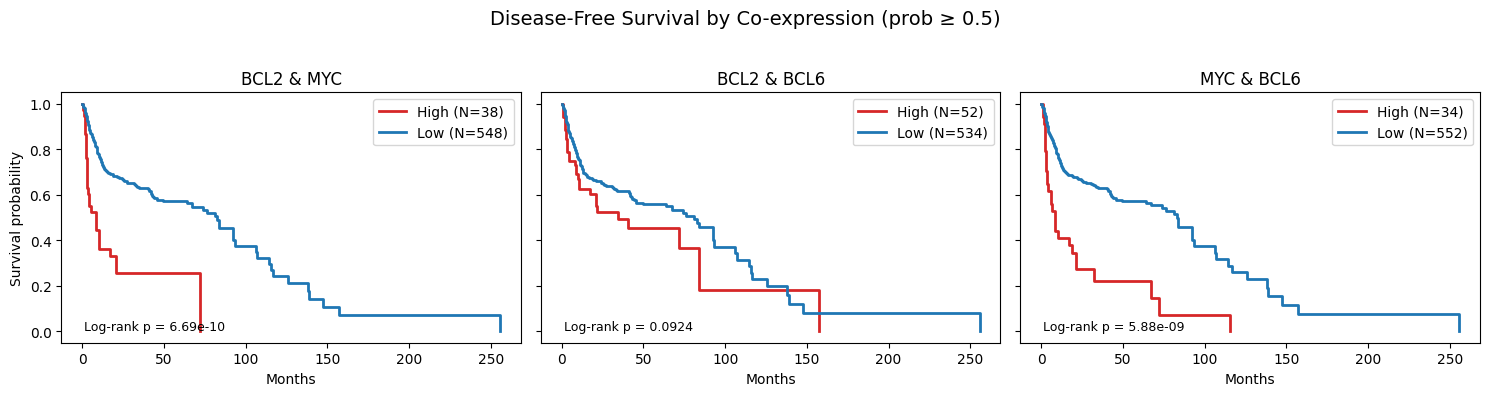

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_DFS/KM_pair_prob_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_DFS/survival_pair_prob_stats_fold4.csv
        Pair  High_N  Low_N     Logrank_p  HR(pair=1 vs 0)  HR 95% CI L  \
0   BCL2_MYC      38    548  6.690241e-10         3.266516     0.786207   
1  BCL2_BCL6      52    534  9.244083e-02         1.402409    -0.056918   
2   MYC_BCL6      34    552  5.878543e-09         3.057899     0.722095   

   HR 95% CI U         Cox_p  
0     1.581242  5.335262e-09  
1     0.733301  9.342155e-02  
2     1.513361  3.073195e-08  


In [62]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH co-expression（DFS，prob）

高危 (High) ：两条通路的预测概率都 ≥ THR  
低危 (Low)  ：其余任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_double_prob_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'
EVENT_COL  = 'DFS Status'
THR        = 0.5                 # 概率阈值

# 要做共表达的基因对
gene_pairs = [
    ('BCL2', 'MYC'),
    ('BCL2', 'BCL6'),
    ('MYC',  'BCL6')
]

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成共表达高危标记
# --------------------------------------------------
for g1, g2 in gene_pairs:
    col1, col2 = f'prob_{g1}', f'prob_{g2}'
    for c in (col1, col2):
        if c not in df.columns:
            raise ValueError(f'缺失列 {c}，请检查预测文件')

    pair_lbl = f'{g1}_{g2}_pair'                # 0 / 1
    df[pair_lbl] = ((df[col1] >= THR) & (df[col2] >= THR)).astype(int)
    df[f'{g1}_{g2}_risk'] = df[pair_lbl].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, axes = plt.subplots(1, len(gene_pairs), figsize=(5*len(gene_pairs), 4), sharey=True)
fig.suptitle(f'Disease-Free Survival by Co-expression (prob ≥ {THR})', fontsize=14)

stats_records = []

for ax, (g1, g2) in zip(axes, gene_pairs):
    risk_col = f'{g1}_{g2}_risk'
    sub      = df.dropna(subset=[risk_col])

    kmf = KaplanMeierFitter()
    colors = {'High': '#d62728', 'Low': '#1f77b4'}

    for grp, g in sub.groupby(risk_col):
        kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
        kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

    # log-rank 检验
    hi = sub[sub[risk_col] == 'High']
    lo = sub[sub[risk_col] == 'Low']
    lr_p = statistics.logrank_test(
        hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
    ).p_value

    ax.set_title(f'{g1} & {g2}')
    ax.set_xlabel('Months')
    if ax is axes[0]:
        ax.set_ylabel('Survival probability')
    ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
            transform=ax.transAxes, fontsize=9)

    stats_records.append({
        'Pair'      : f'{g1}_{g2}',
        'High_N'    : len(hi),
        'Low_N'     : len(lo),
        'Logrank_p' : lr_p
    })

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(out_dir / f'KM_pair_prob_fold{fold}.pdf')
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
for rec, (g1, g2) in zip(stats_records, gene_pairs):
    pair_lbl = f'{g1}_{g2}_pair'
    sub = df[[TIME_COL, EVENT_COL, pair_lbl]].dropna()

    cph = CoxPHFitter()
    try:
        cph.fit(sub.rename(columns={pair_lbl: 'pair'}),
                duration_col=TIME_COL, event_col=EVENT_COL)
        hr   = np.exp(cph.params_['pair'])
        ci_l, ci_u = cph.confidence_intervals_.loc['pair']
        rec.update({
            'HR(pair=1 vs 0)' : hr,
            'HR 95% CI L'     : ci_l,
            'HR 95% CI U'     : ci_u,
            'Cox_p'           : cph.summary.loc['pair', 'p']
        })
    except Exception:
        rec.update({
            'HR(pair=1 vs 0)' : np.nan,
            'HR 95% CI L'     : np.nan,
            'HR 95% CI U'     : np.nan,
            'Cox_p'           : np.nan
        })

stats_df = pd.DataFrame(stats_records)
stats_df.to_csv(out_dir / f'survival_pair_prob_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_pair_prob_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_pair_prob_stats_fold{fold}.csv')
print(stats_df)

# all-expression label OS

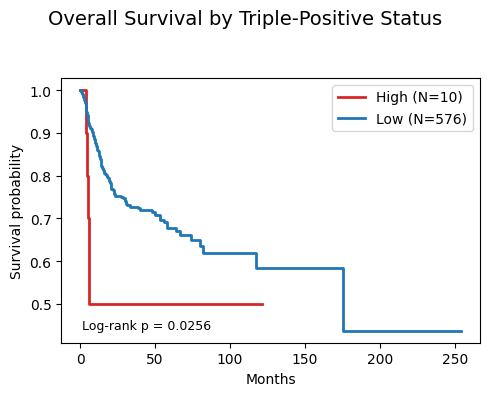

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_OS/KM_triple_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_OS/survival_triple_stats_fold4.csv
   High_N  Low_N  Logrank_p  HR(triple=1 vs 0)  HR 95% CI L  HR 95% CI U  \
0      10    576   0.025624           2.660714     0.085316     1.871873   

      Cox_p  
0  0.031781  


In [67]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三重阳性生存分析（示例：Overall Survival）

High  : label_BCL2 == 1 & label_MYC == 1 & label_BCL6 == 1
Low   : 其他任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_label_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'OS Status'    # 或 'DFS Status'

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成三重阳性风险列
# --------------------------------------------------
need_cols = ['label_BCL2', 'label_MYC', 'label_BCL6']
missing   = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f'预测文件缺失列: {missing}')

df['triple_pos'] = (
    (df['label_BCL2'] == 1) &
    (df['label_MYC'] == 1) &
    (df['label_BCL6'] == 1)
).astype(int)

df['triple_risk'] = df['triple_pos'].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.suptitle('Overall Survival by Triple-Positive Status', fontsize=14)

kmf = KaplanMeierFitter()
colors = {'High': '#d62728', 'Low': '#1f77b4'}

for grp, g in df.groupby('triple_risk'):
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

# log-rank
hi = df[df['triple_risk'] == 'High']
lo = df[df['triple_risk'] == 'Low']
lr_p = statistics.logrank_test(
    hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
).p_value

ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
        transform=ax.transAxes, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(out_dir / f'KM_triple_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
stats = {}
sub = df[[TIME_COL, EVENT_COL, 'triple_pos']].dropna()
cph = CoxPHFitter()
try:
    cph.fit(sub.rename(columns={'triple_pos': 'triple'}),
            duration_col=TIME_COL, event_col=EVENT_COL)
    hr = np.exp(cph.params_['triple'])
    ci_l, ci_u = cph.confidence_intervals_.loc['triple']
    stats = {'High_N'      : len(hi),
             'Low_N'       : len(lo),
             'Logrank_p'   : lr_p,
             'HR(triple=1 vs 0)': hr,
             'HR 95% CI L' : ci_l,
             'HR 95% CI U' : ci_u,
             'Cox_p'       : cph.summary.loc['triple', 'p']}
except Exception:
    stats = {'High_N'      : len(hi),
             'Low_N'       : len(lo),
             'Logrank_p'   : lr_p,
             'HR(triple=1 vs 0)': np.nan,
             'HR 95% CI L' : np.nan,
             'HR 95% CI U' : np.nan,
             'Cox_p'       : np.nan}

stats_df = pd.DataFrame([stats])
stats_df.to_csv(out_dir / f'survival_triple_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_triple_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_triple_stats_fold{fold}.csv')
print(stats_df)

# all-expression prob OS

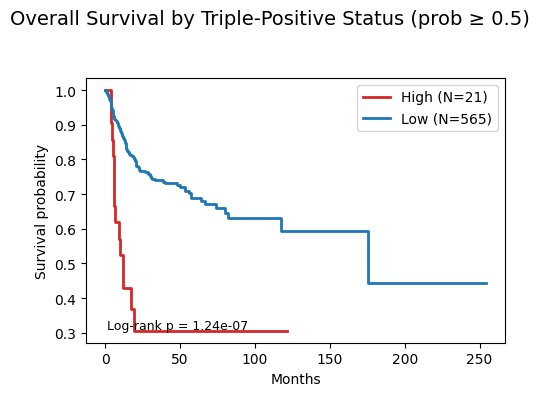

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_OS/KM_triple_prob_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_OS/survival_triple_prob_stats_fold4.csv
   High_N  Low_N     Logrank_p  HR(triple=1 vs 0)  HR 95% CI L  HR 95% CI U  \
0      21    565  1.244104e-07           3.974538     0.827418     1.932399   

          Cox_p  
0  9.818855e-07  


In [72]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三重阳性生存分析 —— prob 版（示例：Overall Survival）

High : 3 个基因的预测概率都 ≥ THR  
Low  : 其余任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 若做 DFS 改为 'DFS(m)'
EVENT_COL  = 'OS Status'    # 若做 DFS 改为 'DFS Status'
THR        = 0.5            # 概率阈值 (≥ THR 视为阳性)

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成三重阳性风险列
# --------------------------------------------------
prob_cols = ['prob_BCL2', 'prob_MYC', 'prob_BCL6']
missing   = [c for c in prob_cols if c not in df.columns]
if missing:
    raise ValueError(f'预测文件缺失列: {missing}')

df['triple_pos'] = (
    (df['prob_BCL2'] >= THR) &
    (df['prob_MYC']  >= THR) &
    (df['prob_BCL6'] >= THR)
).astype(int)

df['triple_risk'] = df['triple_pos'].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.suptitle(f'Overall Survival by Triple-Positive Status (prob ≥ {THR})', fontsize=14)

kmf    = KaplanMeierFitter()
colors = {'High': '#d62728', 'Low': '#1f77b4'}

for grp, g in df.groupby('triple_risk'):
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

# log-rank
hi   = df[df['triple_risk'] == 'High']
lo   = df[df['triple_risk'] == 'Low']
lr_p = statistics.logrank_test(
    hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
).p_value

ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
        transform=ax.transAxes, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(out_dir / f'KM_triple_prob_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
stats = {}
sub = df[[TIME_COL, EVENT_COL, 'triple_pos']].dropna()
cph = CoxPHFitter()
try:
    cph.fit(sub.rename(columns={'triple_pos': 'triple'}),
            duration_col=TIME_COL, event_col=EVENT_COL)
    hr   = np.exp(cph.params_['triple'])
    ci_l, ci_u = cph.confidence_intervals_.loc['triple']
    stats = {
        'High_N'              : len(hi),
        'Low_N'               : len(lo),
        'Logrank_p'           : lr_p,
        'HR(triple=1 vs 0)'   : hr,
        'HR 95% CI L'         : ci_l,
        'HR 95% CI U'         : ci_u,
        'Cox_p'               : cph.summary.loc['triple', 'p']
    }
except Exception:
    stats = {
        'High_N'              : len(hi),
        'Low_N'               : len(lo),
        'Logrank_p'           : lr_p,
        'HR(triple=1 vs 0)'   : np.nan,
        'HR 95% CI L'         : np.nan,
        'HR 95% CI U'         : np.nan,
        'Cox_p'               : np.nan
    }

stats_df = pd.DataFrame([stats])
stats_df.to_csv(out_dir / f'survival_triple_prob_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_triple_prob_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_triple_prob_stats_fold{fold}.csv')
print(stats_df)

# all-expression label DFS

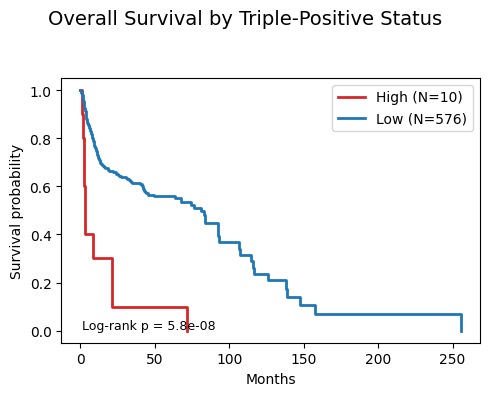

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_label_DFS/KM_triple_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_label_DFS/survival_triple_stats_fold4.csv
   High_N  Low_N     Logrank_p  HR(triple=1 vs 0)  HR 95% CI L  HR 95% CI U  \
0      10    576  5.796738e-08           4.907357     0.954997     2.226474   

          Cox_p  
0  9.381192e-07  


In [77]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三重阳性生存分析（示例：Overall Survival）

High  : label_BCL2 == 1 & label_MYC == 1 & label_BCL6 == 1
Low   : 其他任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_label_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'        # 或 'DFS(m)'
EVENT_COL  = 'DFS Status'    # 或 'DFS Status'

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成三重阳性风险列
# --------------------------------------------------
need_cols = ['label_BCL2', 'label_MYC', 'label_BCL6']
missing   = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f'预测文件缺失列: {missing}')

df['triple_pos'] = (
    (df['label_BCL2'] == 1) &
    (df['label_MYC'] == 1) &
    (df['label_BCL6'] == 1)
).astype(int)

df['triple_risk'] = df['triple_pos'].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.suptitle('Overall Survival by Triple-Positive Status', fontsize=14)

kmf = KaplanMeierFitter()
colors = {'High': '#d62728', 'Low': '#1f77b4'}

for grp, g in df.groupby('triple_risk'):
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

# log-rank
hi = df[df['triple_risk'] == 'High']
lo = df[df['triple_risk'] == 'Low']
lr_p = statistics.logrank_test(
    hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
).p_value

ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
        transform=ax.transAxes, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(out_dir / f'KM_triple_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
stats = {}
sub = df[[TIME_COL, EVENT_COL, 'triple_pos']].dropna()
cph = CoxPHFitter()
try:
    cph.fit(sub.rename(columns={'triple_pos': 'triple'}),
            duration_col=TIME_COL, event_col=EVENT_COL)
    hr = np.exp(cph.params_['triple'])
    ci_l, ci_u = cph.confidence_intervals_.loc['triple']
    stats = {'High_N'      : len(hi),
             'Low_N'       : len(lo),
             'Logrank_p'   : lr_p,
             'HR(triple=1 vs 0)': hr,
             'HR 95% CI L' : ci_l,
             'HR 95% CI U' : ci_u,
             'Cox_p'       : cph.summary.loc['triple', 'p']}
except Exception:
    stats = {'High_N'      : len(hi),
             'Low_N'       : len(lo),
             'Logrank_p'   : lr_p,
             'HR(triple=1 vs 0)': np.nan,
             'HR 95% CI L' : np.nan,
             'HR 95% CI U' : np.nan,
             'Cox_p'       : np.nan}

stats_df = pd.DataFrame([stats])
stats_df.to_csv(out_dir / f'survival_triple_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_triple_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_triple_stats_fold{fold}.csv')
print(stats_df)

# all-expression prob DFS

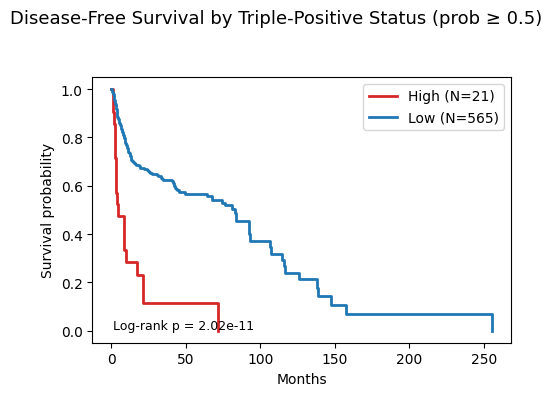

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_DFS/KM_triple_prob_fold4.pdf
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_DFS/survival_triple_prob_stats_fold4.csv
   High_N  Low_N     Logrank_p  HR(triple=1 vs 0)  HR 95% CI L  HR 95% CI U  \
0      21    565  2.016882e-11             4.3919      1.00771     1.951814   

          Cox_p  
0  8.047436e-10  


In [82]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH 三重阳性生存分析 —— prob 版（Disease-Free Survival 示例）

High : prob_BCL2 ≥ THR 且 prob_MYC ≥ THR 且 prob_BCL6 ≥ THR  
Low  : 其它任何情况

依赖：
    pip install lifelines matplotlib pandas numpy openpyxl
"""

# --------------------------------------------------
# 0. 导入
# --------------------------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter

# --------------------------------------------------
# 1. 路径与参数（★按需修改★）
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_triple_prob_DFS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'DFS(m)'        # 若做 OS 改为 'OS(m)'
EVENT_COL  = 'DFS Status'    # 若做 OS 改为 'OS Status'
THR        = 0.5             # 概率阈值

# --------------------------------------------------
# 2. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 3. 生成三重阳性风险列
# --------------------------------------------------
prob_cols = ['prob_BCL2', 'prob_MYC', 'prob_BCL6']
missing   = [c for c in prob_cols if c not in df.columns]
if missing:
    raise ValueError(f'预测文件缺失列: {missing}')

df['triple_pos'] = (
    (df['prob_BCL2'] >= THR) &
    (df['prob_MYC']  >= THR) &
    (df['prob_BCL6'] >= THR)
).astype(int)

df['triple_risk'] = df['triple_pos'].map({1: 'High', 0: 'Low'})

# --------------------------------------------------
# 4. 绘制 KM 曲线
# --------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
fig.suptitle(f'Disease-Free Survival by Triple-Positive Status (prob ≥ {THR})',
             fontsize=13)

kmf    = KaplanMeierFitter()
colors = {'High': '#d62728', 'Low': '#1f77b4'}

for grp, g in df.groupby('triple_risk'):
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    kmf.plot(ax=ax, ci_show=False, color=colors.get(grp), lw=2)

# log-rank
hi   = df[df['triple_risk'] == 'High']
lo   = df[df['triple_risk'] == 'Low']
lr_p = statistics.logrank_test(
    hi[TIME_COL], lo[TIME_COL], hi[EVENT_COL], lo[EVENT_COL]
).p_value

ax.set_xlabel('Months')
ax.set_ylabel('Survival probability')
ax.text(0.05, 0.05, f'Log-rank p = {lr_p:.3g}',
        transform=ax.transAxes, fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(out_dir / f'KM_triple_prob_fold{fold}.pdf', dpi=300)
plt.show()

# --------------------------------------------------
# 5. Cox 回归
# --------------------------------------------------
stats = {}
sub  = df[[TIME_COL, EVENT_COL, 'triple_pos']].dropna()
cph  = CoxPHFitter()
try:
    cph.fit(sub.rename(columns={'triple_pos': 'triple'}),
            duration_col=TIME_COL, event_col=EVENT_COL)
    hr   = np.exp(cph.params_['triple'])
    ci_l, ci_u = cph.confidence_intervals_.loc['triple']
    stats = {'High_N'            : len(hi),
             'Low_N'             : len(lo),
             'Logrank_p'         : lr_p,
             'HR(triple=1 vs 0)' : hr,
             'HR 95% CI L'       : ci_l,
             'HR 95% CI U'       : ci_u,
             'Cox_p'             : cph.summary.loc['triple', 'p']}
except Exception:
    stats = {'High_N'            : len(hi),
             'Low_N'             : len(lo),
             'Logrank_p'         : lr_p,
             'HR(triple=1 vs 0)' : np.nan,
             'HR 95% CI L'       : np.nan,
             'HR 95% CI U'       : np.nan,
             'Cox_p'             : np.nan}

stats_df = pd.DataFrame([stats])
stats_df.to_csv(out_dir / f'survival_triple_prob_stats_fold{fold}.csv', index=False)

print('KM 图保存至:', out_dir / f'KM_triple_prob_fold{fold}.pdf')
print('统计表保存至:', out_dir / f'survival_triple_prob_stats_fold{fold}.csv')
print(stats_df)

# group

In [28]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
BH-TCH  |  Disease-Free-Survival  |  组合风险分层 (0/1/≥2 positives)

风险定义
    prob_BCL2 ≥ THR 记 1
    prob_MYC  ≥ THR 记 1
    prob_BCL6 ≥ THR 记 1
    n_positive = 0 → Low
                 1 → Intermediate
                 ≥2→ High

输出
    KM_CompositeRisk.png           三组 DFS KM 曲线
    survival_stats_composite.csv   统计表：N、log-rank P、HR、95%CI、Cox_P
"""

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

# --------------------------------------------------
# 0. 路径与参数
# --------------------------------------------------
fold        = 4
group_path  = '/data/ceiling/workspace/DLBLC/dataset_csv/BH_TCH(merge).xlsx'
pred_path   = f'/data/ceiling/workspace/DLBLC/results/Beijing_all/s_{fold}_checkpoint.csv'

out_dir     = Path('/data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_composite_OS')
out_dir.mkdir(parents=True, exist_ok=True)

TIME_COL   = 'OS(m)'        # 改成你的列名：DFS(m) / OS(m) …
EVENT_COL  = 'OS Status'    # 1=事件，0=删失
THR        = 0.50            # 阳性判定阈值

# --------------------------------------------------
# 1. 读取并合并
# --------------------------------------------------
group_df = pd.read_excel(group_path)
pred_df  = pd.read_csv(pred_path)

df = pred_df.merge(
        group_df[['slide_id', TIME_COL, EVENT_COL]],
        on='slide_id', how='left'
     ).dropna(subset=[TIME_COL, EVENT_COL])

# --------------------------------------------------
# 2. 自定义组合风险分层
# --------------------------------------------------
def row2risk(row, thr=THR):
    n_pos = int((row['prob_BCL2'] >= thr)
              + (row['prob_MYC']  >= thr)
              + (row['prob_BCL6'] >= thr))
    if n_pos == 0:
        return 'Low'
    elif n_pos == 1:
        return 'Intermediate'
    else:
        return 'High'

df['risk_grp'] = df.apply(row2risk, axis=1)
df['n_positive'] = df[['prob_BCL2','prob_MYC','prob_BCL6']].ge(THR).sum(1)

# --------------------------------------------------
# 3. Kaplan–Meier 曲线
# --------------------------------------------------
kmf     = KaplanMeierFitter()
colors  = {'Low': '#1f77b4', 'Intermediate': '#ff7f0e', 'High': '#d62728'}
plt.figure(figsize=(6,5))

for grp, g in df.groupby('risk_grp', sort=False):
    kmf.fit(g[TIME_COL], g[EVENT_COL], label=f'{grp} (N={len(g)})')
    kmf.plot(ci_show=False, lw=2, color=colors.get(grp))

plt.title('DFS by Composite Risk (0/1/≥2 positives)')
plt.xlabel('Months'); plt.ylabel('Survival probability')
plt.tight_layout()
km_pdf = out_dir / f'KM_CompositeRisk_fold{fold}.pdf'
plt.savefig(km_pdf, dpi=300)
plt.close()

# --------------------------------------------------
# 4. log-rank 统计
# --------------------------------------------------
stats = {}

# 全局 3 组
stats['Global_logrank_p'] = multivariate_logrank_test(
    df[TIME_COL], df['risk_grp'], df[EVENT_COL]).p_value

# 两两比较
pairs = [('High','Low'), ('High','Intermediate'), ('Intermediate','Low')]
for g1, g2 in pairs:
    d1, d2 = df.query('risk_grp == @g1'), df.query('risk_grp == @g2')
    p = logrank_test(
            d1[TIME_COL], d2[TIME_COL],
            d1[EVENT_COL], d2[EVENT_COL]).p_value
    stats[f'Logrank_{g1}_vs_{g2}_p'] = p

# --------------------------------------------------
# 5. Cox 回归 (n_positive 连续;  及 risk_grp 分类)
# --------------------------------------------------
cox_records = []
# 5-a 连续得分：每增加 1 阳性 hazard
cph = CoxPHFitter()
cph.fit(df[[TIME_COL, EVENT_COL, 'n_positive']],
        duration_col=TIME_COL, event_col=EVENT_COL)
hr = np.exp(cph.params_['n_positive'])
ci_l, ci_u = cph.confidence_intervals_.loc['n_positive']
cox_p = cph.summary.loc['n_positive','p']
stats.update({'HR_per_positive': hr,
              'HR_CI_L': ci_l, 'HR_CI_U': ci_u,
              'Cox_p_per_positive': cox_p})

# --------------------------------------------------
# 5-b 风险组分类（Low 参考）
# --------------------------------------------------
df_cat = pd.get_dummies(
    df[[TIME_COL, EVENT_COL, 'risk_grp']].copy(),
    columns=['risk_grp'], drop_first=True           # 生成 risk_grp_Intermediate / risk_grp_High
)
cat_cols = [c for c in df_cat.columns if c.startswith('risk_grp_')]

cph2 = CoxPHFitter()
cph2.fit(df_cat[[TIME_COL, EVENT_COL] + cat_cols],
         duration_col=TIME_COL, event_col=EVENT_COL)

for c in cat_cols:
    hr = np.exp(cph2.params_[c])
    ci_l, ci_u = cph2.confidence_intervals_.loc[c]
    stats[f'HR_{c}(vs_Low)'] = hr
    stats[f'CI_L_{c}']       = ci_l
    stats[f'CI_U_{c}']       = ci_u
    stats[f'Cox_p_{c}']      = cph2.summary.loc[c,'p']

# --------------------------------------------------
# 6. 组别样本量
# --------------------------------------------------
for grp, g in df.groupby('risk_grp'):
    stats[f'N_{grp}'] = len(g)

# --------------------------------------------------
# 7. 保存统计表
# --------------------------------------------------
stats_df = pd.DataFrame([stats])
csv_file = out_dir / f'survival_stats_composite_fold{fold}.csv'
stats_df.to_csv(csv_file, index=False)

print('KM 图保存至:', km_pdf)
print('统计表保存至:', csv_file)
print('\n===== summary =====')
print(stats_df.T)

KM 图保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_composite_OS/KM_CompositeRisk_fold4.png
统计表保存至: /data/ceiling/workspace/DLBLC/evaluation/Beijing/survival_composite_OS/survival_stats_composite_fold4.csv

===== summary =====
                                           0
Global_logrank_p                    0.023591
Logrank_High_vs_Low_p               0.009049
Logrank_High_vs_Intermediate_p      0.025807
Logrank_Intermediate_vs_Low_p       0.481168
HR_per_positive                     1.398871
HR_CI_L                             0.136734
HR_CI_U                             0.534597
Cox_p_per_positive                  0.000943
HR_risk_grp_Intermediate(vs_Low)    0.623334
CI_L_risk_grp_Intermediate         -0.891647
CI_U_risk_grp_Intermediate         -0.053697
Cox_p_risk_grp_Intermediate         0.027025
HR_risk_grp_Low(vs_Low)             0.545892
CI_L_risk_grp_Low                  -1.055986
CI_U_risk_grp_Low                  -0.154681
Cox_p_risk_grp_Low                  0.